# Library import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from  scipy.stats import skew, kurtosis, shapiro

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
dmd = pd.read_csv('VIC2014-2021.csv')

In [5]:
dmd

,Datetime,Demand,Price
0,2014/1/1 0:30,4656.030000,44.040000
1,2014/1/1 1:00,4373.040000,41.440000
2,2014/1/1 1:30,4175.320000,37.100000
3,2014/1/1 2:00,4003.350000,33.790000
4,2014/1/1 2:30,3841.740000,20.410000
...,...,...,...
140249,2021/12/31 21:30,5657.276667,87.200000
140250,2021/12/31 22:00,5407.026667,123.723333
140251,2021/12/31 22:30,5291.213333,120.326667
140252,2021/12/31 23:00,5314.540000,109.208333


# [Data processing] Convert the timestamps to the type 'Datetime' (that time series model can understand)

In [6]:
dmd['Datetime'] = pd.to_datetime(dmd['Datetime'],format='%Y-%m-%d %H:%M')

In [7]:
dmd.sort_values(by='Datetime',inplace=True)
dmd.set_index('Datetime',inplace=True)

In [8]:
dmd

,Demand,Price
Datetime,,
2014-01-01 00:30:00,4656.030000,44.040000
2014-01-01 01:00:00,4373.040000,41.440000
2014-01-01 01:30:00,4175.320000,37.100000
2014-01-01 02:00:00,4003.350000,33.790000
2014-01-01 02:30:00,3841.740000,20.410000
...,...,...
2021-12-31 21:30:00,5657.276667,87.200000
2021-12-31 22:00:00,5407.026667,123.723333
2021-12-31 22:30:00,5291.213333,120.326667


# [Data processing] Resample the demand data and price from half-hourly to daily, by sum and by average, respectively.

In [9]:
dmd1 = dmd.resample('D').mean()

In [10]:
dmd2 = dmd.resample('D').sum()

In [11]:
dmd1['Demand']= dmd2['Demand']

In [12]:
dmd1

,Demand,Price
Datetime,,
2014-01-01,201465.190000,36.769149
2014-01-02,230442.770000,43.859375
2014-01-03,226672.910000,44.148333
2014-01-04,208400.340000,42.769583
2014-01-05,202206.160000,40.518333
...,...,...
2021-12-27,156773.616666,-23.518194
2021-12-28,160029.526664,-3.293576
2021-12-29,184253.431671,26.780000


# Build box plot of the daily electricity demand and price

In [13]:
dmd1["year"] = dmd1.index.year
dmd1["mon"] = dmd1.index.month
dmd1["week"] = dmd1.index.week
dmd1["day"] = dmd1.index.weekday
dmd1["ix"] = range(0,len(dmd1))

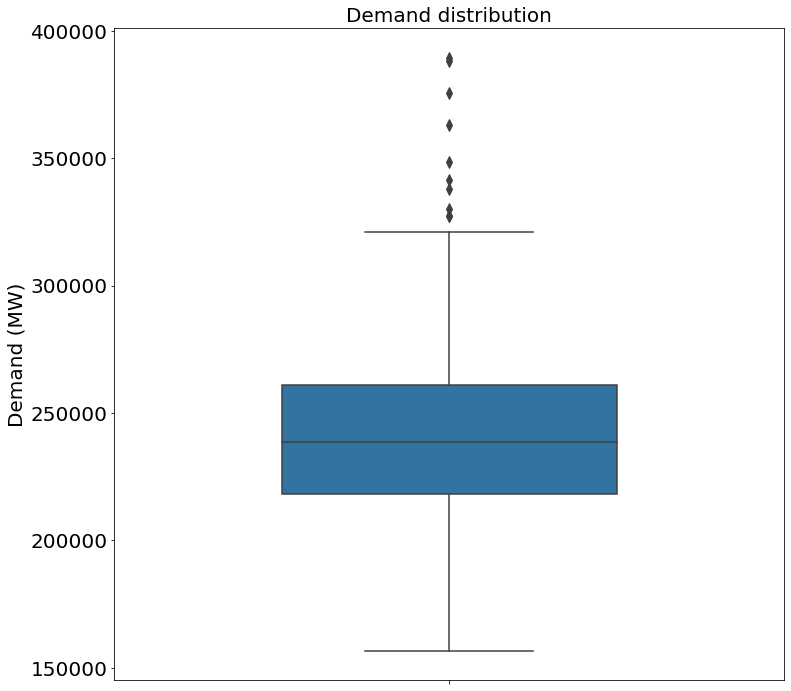

In [14]:
plt.figure(figsize=(12,12))
plt.yticks(fontsize=20)
sns.boxplot(dmd1['Demand'],orient="v",width=0.5,fliersize=8)
plt.ylabel('Demand (MW)',fontsize=20)
plt.title('Demand distribution',fontsize=20)
plt.savefig('D:\py3320_proj/fig7.svg')

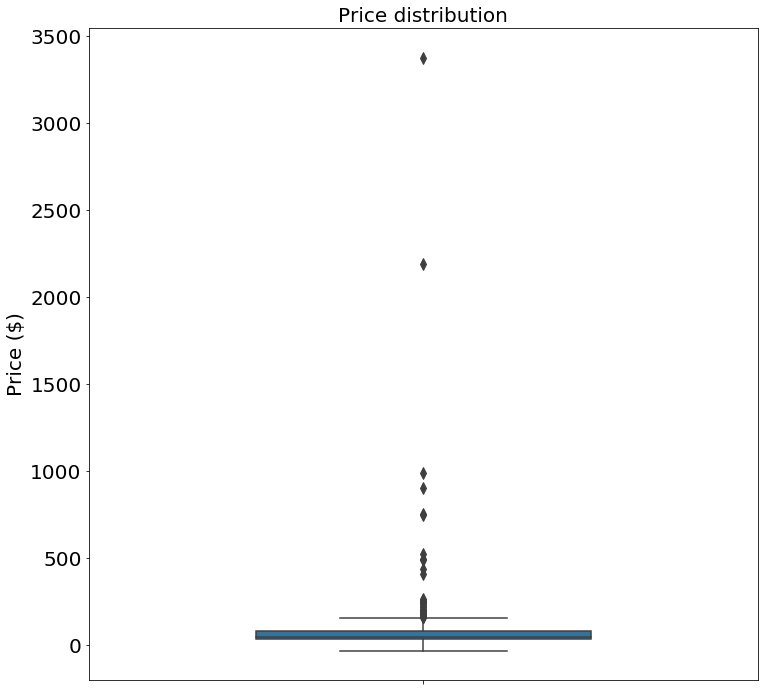

In [15]:
plt.figure(figsize=(12,12))
plt.yticks(fontsize=20)
sns.boxplot(dmd1['Price'],orient="v",width=0.5,fliersize=8)
plt.ylabel('Price ($)',fontsize=20)
plt.title('Price distribution',fontsize=20)
plt.savefig('D:\py3320_proj/fig8.svg')

# Normality Analysis

In [16]:
mean = np.mean(dmd1.Demand.values)
std = np.std(dmd1.Demand.values)
skew = skew(dmd1.Demand.values)
ex_kurt = kurtosis(dmd1.Demand)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.2737066983387573 
Kurtosis: 3.257092524179736


In [17]:
def shapiro_test(data, alpha=0.01):
    stat, p_value = shapiro(data)
    print("H0: Data was drawn from a Normal Ditribution")
    if (p_value<alpha):
        print("p-value {} is lower than significance level: {}, therefore null hypothesis is rejected".format(p_value, alpha))
    else:
        print("p-value {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(p_value, alpha))
        
shapiro_test(dmd1.Demand, alpha=0.01)

H0: Data was drawn from a Normal Ditribution
p-value 1.3868956981119562e-12 is lower than significance level: 0.01, therefore null hypothesis is rejected


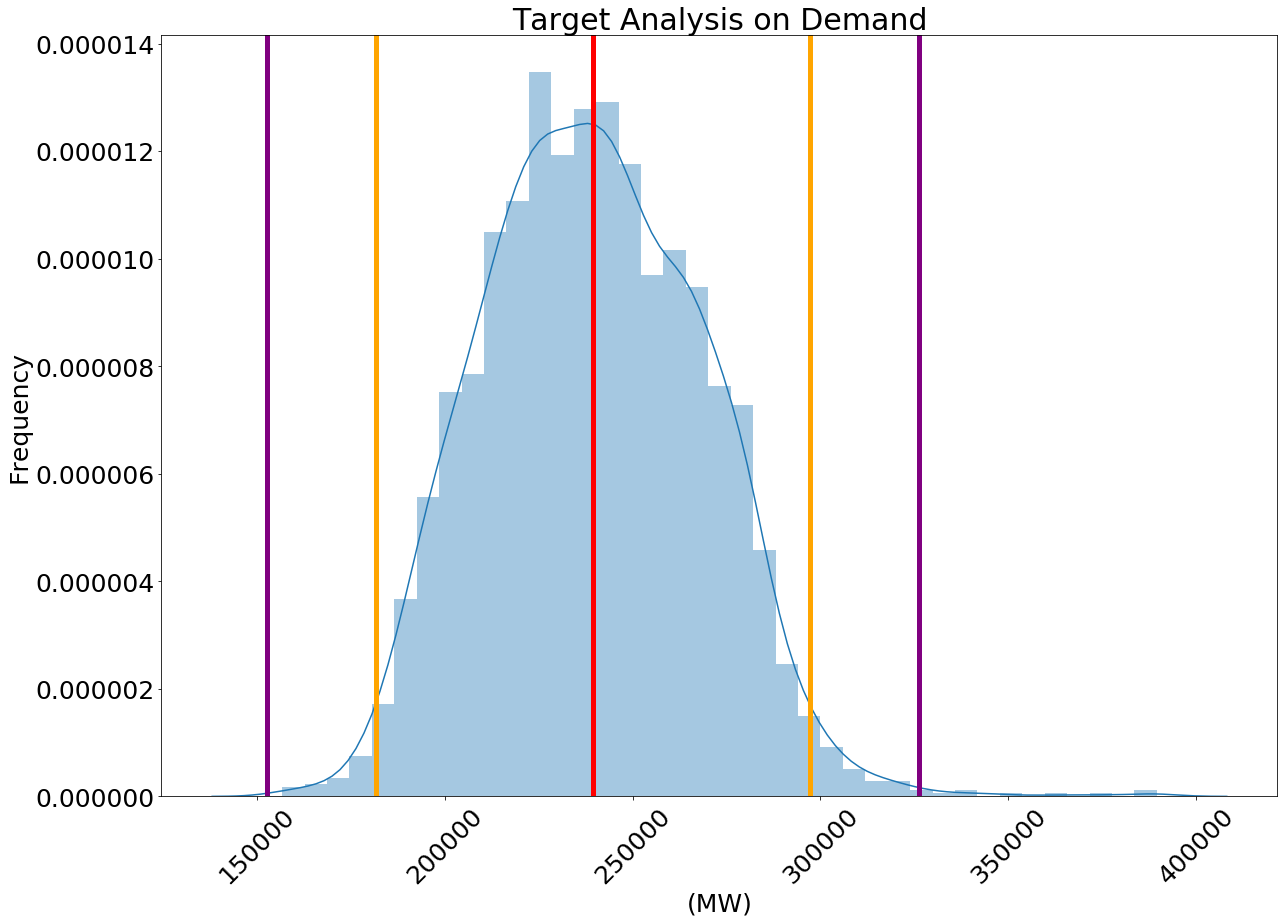

In [18]:
plt.figure(figsize=(20,14))
sns.distplot(dmd1.Demand)
plt.title("Target Analysis on Demand",fontsize=30)
plt.xticks(rotation=45,fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("(MW)",fontsize=25)
plt.ylabel("Frequency",fontsize=25)
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean),linewidth=5)
plt.axvline(x=mean+2*std, color='orange', linestyle='-',linewidth=5)
plt.axvline(x=mean-2*std, color='orange', linestyle='-',linewidth=5)
plt.axvline(x=mean+3*std, color='purple', linestyle='-',linewidth=5)
plt.axvline(x=mean-3*std, color='purple', linestyle='-',linewidth=5)
plt.savefig('D:\py3320_proj.svg')
plt.show()

# resample the demand to monthly and do the linear regression analysis

In [19]:
dmd_mon = dmd1.resample('M').sum()
dmd = pd.read_csv('VIC2014-2021.csv')

In [20]:
dmd_mon

,Demand,Price,year,mon,week,day,ix
Datetime,,,,,,,
2014-01-31,8.412518e+06,2244.980191,62434,31,93,93,465
2014-02-28,7.647694e+06,1379.110000,56392,56,202,84,1246
2014-03-31,7.925168e+06,1424.700417,62434,93,354,95,2294
2014-04-30,7.454656e+06,1313.448333,60420,120,474,87,3135
2014-05-31,8.097877e+06,1494.512292,62434,155,624,96,4185
...,...,...,...,...,...,...,...
2021-08-31,7.478668e+06,1457.381667,62651,248,1010,91,86304
2021-09-30,6.536996e+06,832.654792,60630,270,1108,89,84435
2021-10-31,6.457018e+06,572.051250,62651,310,1279,99,88195


In [21]:
dmd_mon['ix'] = range(0,len(dmd_mon))

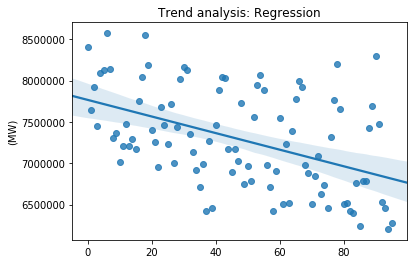

In [22]:
sns.regplot(data=dmd_mon,x='ix', y="Demand")
plt.title("Trend analysis: Regression")
plt.ylabel("(MW)")
plt.xlabel("")
plt.show()

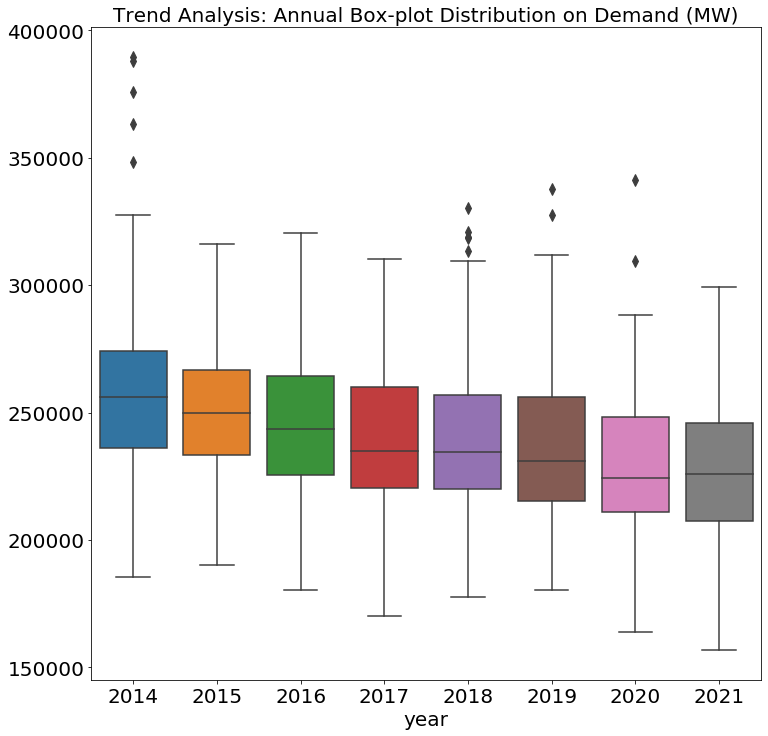

In [23]:
plt.figure(figsize=(12,12))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('year',fontsize=20)
sns.boxplot(data=dmd1["2014":"2021"], x="year", y="Demand",fliersize=8)
plt.ylabel('')
plt.title("Trend Analysis: Annual Box-plot Distribution on Demand (MW)",fontsize=20)
plt.savefig('D:\py3320_proj/fig10.svg')
plt.show()

# Feature Engineering

In [24]:
dmd1

,Demand,Price,year,mon,week,day,ix
Datetime,,,,,,,
2014-01-01,201465.190000,36.769149,2014,1,1,2,0
2014-01-02,230442.770000,43.859375,2014,1,1,3,1
2014-01-03,226672.910000,44.148333,2014,1,1,4,2
2014-01-04,208400.340000,42.769583,2014,1,1,5,3
2014-01-05,202206.160000,40.518333,2014,1,1,6,4
...,...,...,...,...,...,...,...
2021-12-27,156773.616666,-23.518194,2021,12,52,0,2917
2021-12-28,160029.526664,-3.293576,2021,12,52,1,2918
2021-12-29,184253.431671,26.780000,2021,12,52,2,2919


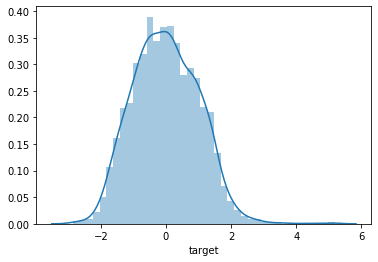

In [25]:
dmd1["target"] = dmd1.Demand.add(-mean).div(std)
sns.distplot(dmd1["target"])
plt.show()

In [26]:
#code derived from kaggle 

features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    dmd1["target_t" + str(t)] = dmd1.target.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,31):
    dmd1["feat_ar" + str(t)] = dmd1.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    dmd1[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = dmd1.Demand.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(dmd1.mon,
                              prefix="mon",
                              drop_first=True)
months.index = dmd1.index
dmd1 = pd.concat([dmd1, months], axis=1)

days = pd.get_dummies(dmd1.day,
                              prefix="day",
                              drop_first=True)
days.index = dmd1.index
dmd1 = pd.concat([dmd1, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

In [27]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

In [28]:
dmd1[["movave_7", "movstd_7"]] = dmd1.Demand.rolling(7).agg([np.mean, np.std])
dmd1[["movave_30", "movstd_30"]] = dmd1.Demand.rolling(30).agg([np.mean, np.std])

In [29]:
corr = dmd1[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]

<Figure size 1440x1440 with 0 Axes>

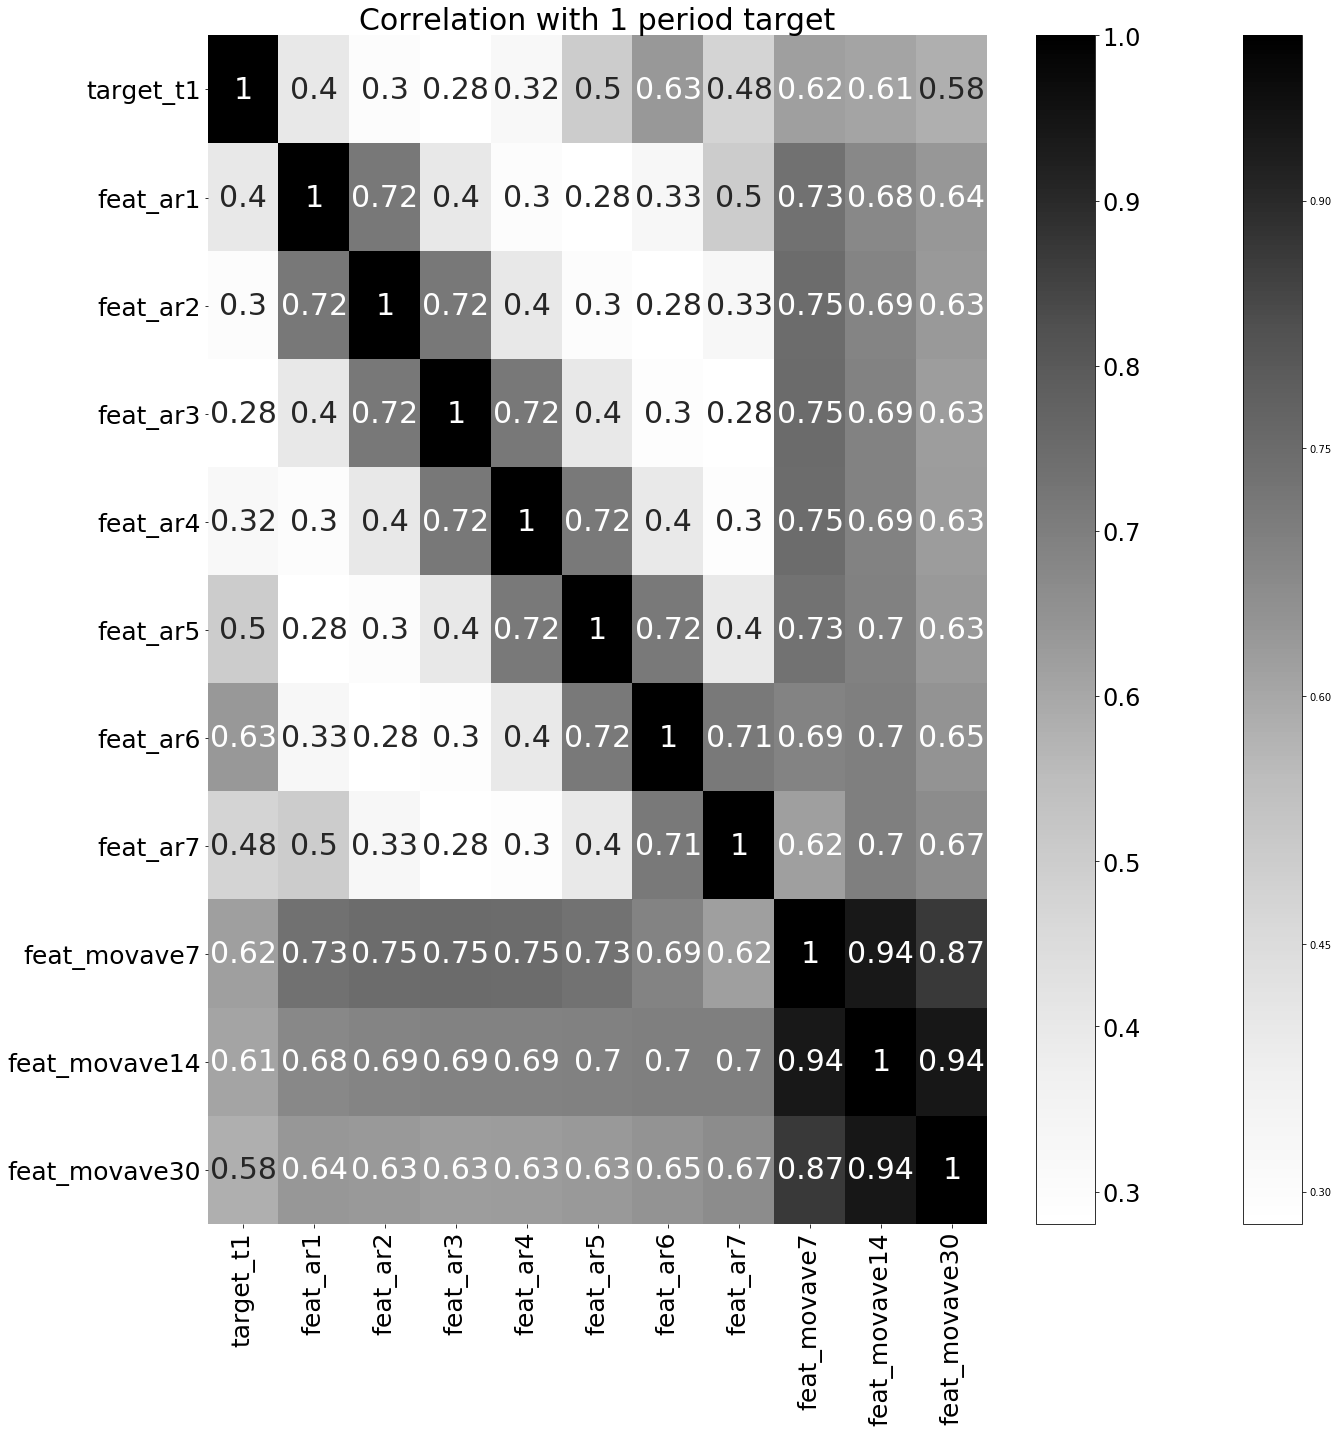

In [30]:
# Plot heatmap of correlation matrix

plt.figure(figsize=(20,20))
f,ax = plt.subplots(figsize = (20,20))
h = sns.heatmap(corr, annot=True,cmap='Greys',annot_kws={'size':30})
bottom, top = ax.get_ylim()
h.set_ylim(bottom + 0.5, top - 0.5)
cb=h.figure.colorbar(h.collections[0])
cb.ax.tick_params(labelsize=24)
plt.title("Correlation with 1 period target",fontsize=30)
plt.yticks(rotation=0,fontsize=25,); plt.xticks(rotation=90,fontsize=25)  # fix ticklabel directions
plt.tight_layout()
plt.savefig('D:\py3320_proj/fig12.svg')
plt.show()  # show the plot

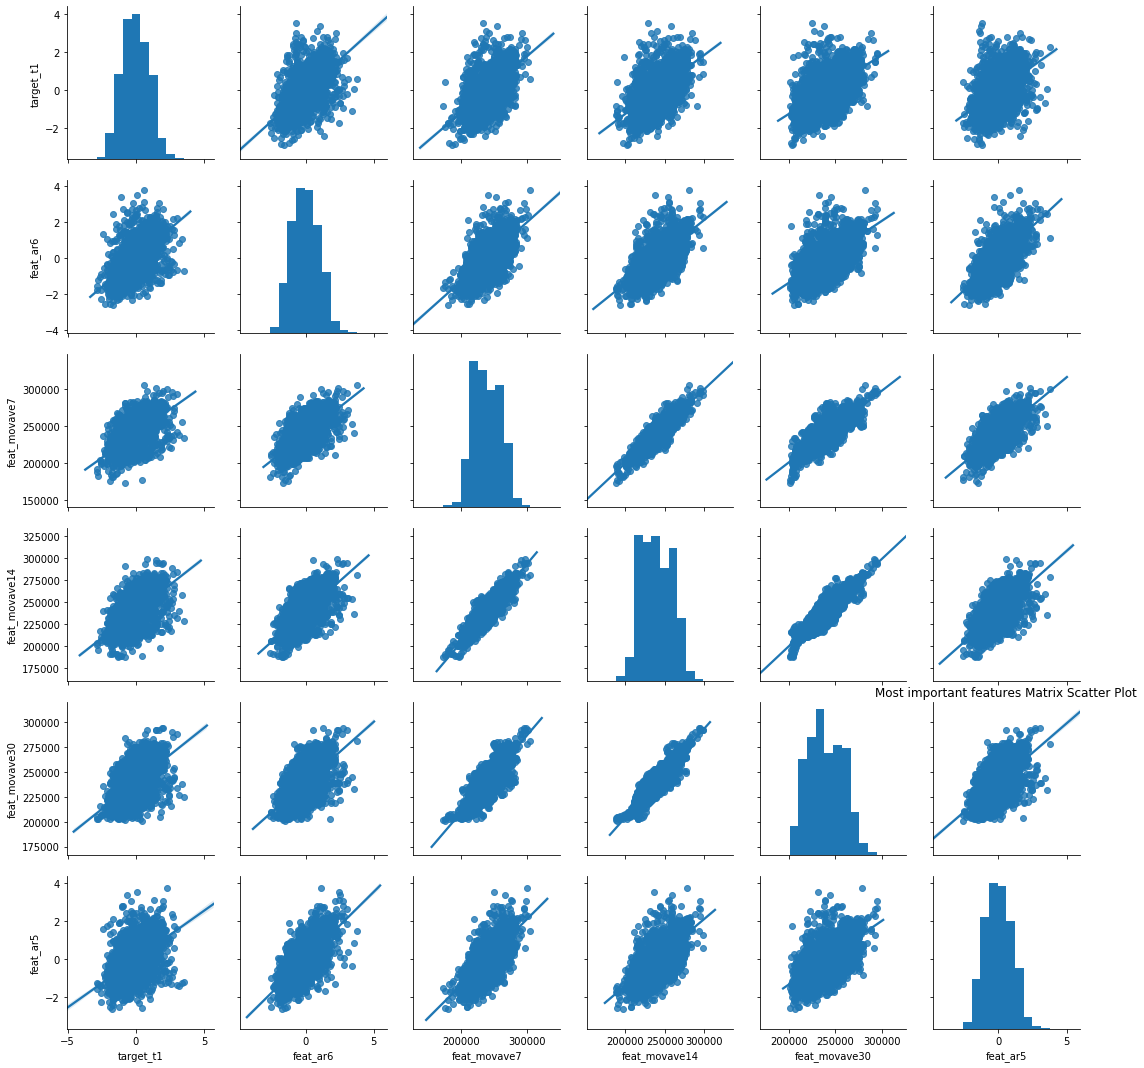

In [31]:
sns.pairplot(data=dmd1[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

# model build

In [32]:
data_feateng = dmd1[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

Number of observations:  2862


Total number of observations:  2862
Train: (2527, 59)(2527, 30), 
Test: (335, 59)(335, 30)


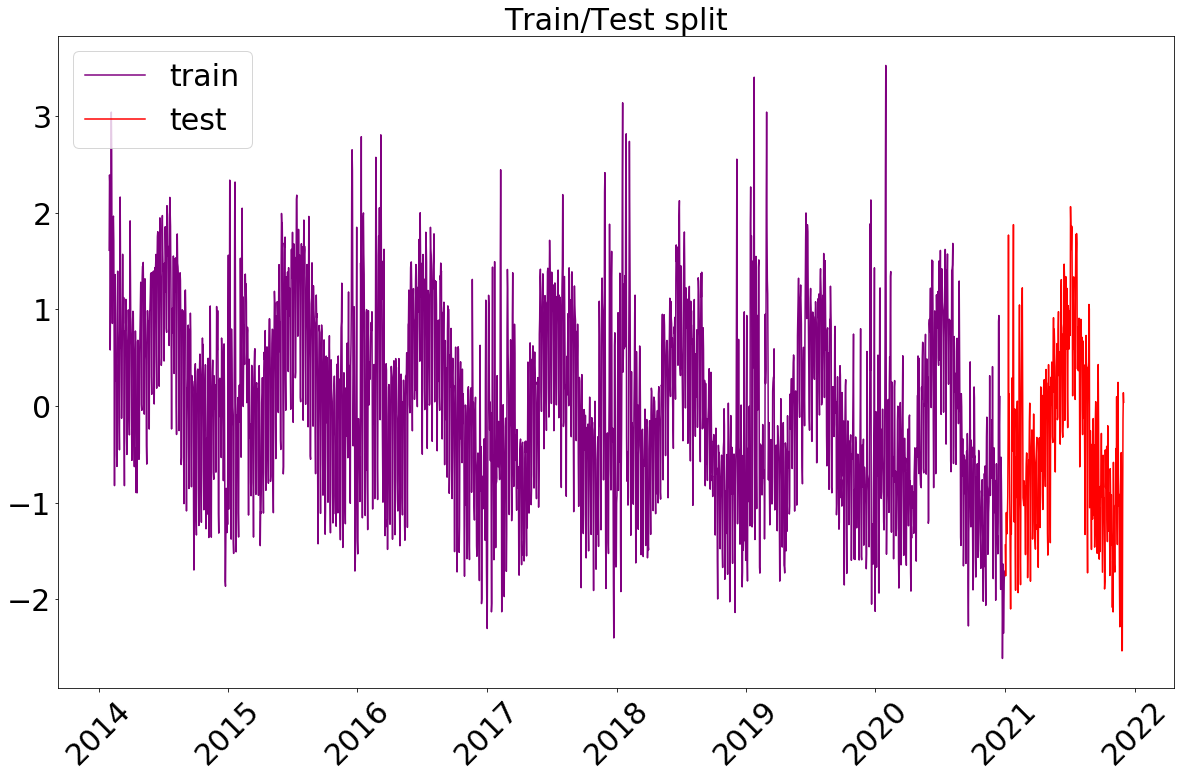

In [33]:
X_train = data_feateng.loc["2014":"2020"][features]
y_train = data_feateng.loc["2014":"2020"][targets]

X_test = data_feateng.loc["2021"][features]
y_test = data_feateng.loc["2021"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.figure(figsize=(20,12))
plt.plot(y_train.index, y_train.target_t1.values, label="train",color='purple')
plt.plot(y_test.index, y_test.target_t1.values, label="test",color='red')
plt.title("Train/Test split",fontsize=30)
plt.xticks(rotation=45,fontsize=30)
plt.yticks(fontsize=30)
plt.legend(loc='upper left',fontsize=30)
plt.savefig('D:\py3320_proj/fig13.svg')
plt.show()

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 0.4592245483570332
Test RMSE: 0.4639768863482391


# Different from the previous one, this time we want to get hyperparameters of best performance and build the model with that. We iterate the hyperparameters, since too many possible combinations, we use RandomSearchCV to help us select 2000 combinations from them, with 3-fold cross validation

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [int(y) for y in np.linspace(start = 1, stop = 11, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 10, num = 9)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2000, cv = 3, verbose=2, random_state=100, n_jobs = -1)
rf_random.fit(X_train, y_train)

# Now we get the best parameter grid, use it to build the model and evaluate it by calculating MAPE

In [37]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 11,
 'max_depth': 70,
 'bootstrap': False}

In [83]:
best_rfr = RandomForestRegressor().set_params(**rf_random.best_params_).\
    fit(X_train.loc["2014":"2020"], y_train.loc["2014":"2020", "target_t1"])

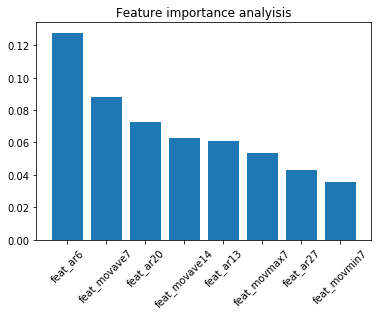

In [84]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:8]
x = range(len(sorted_index_top))
# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()


In [85]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

In [86]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = np.abs(test_df["resid_t1"].div(test_df["target_t1"]))

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  5.5310532167767334


# Generate the scatter plot and line chart of the comparsion between the forecasting result and actual value of 2021 demand 

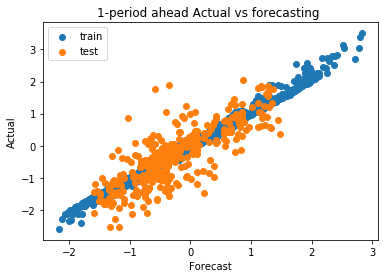

In [87]:
plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()

<Figure size 1440x864 with 0 Axes>

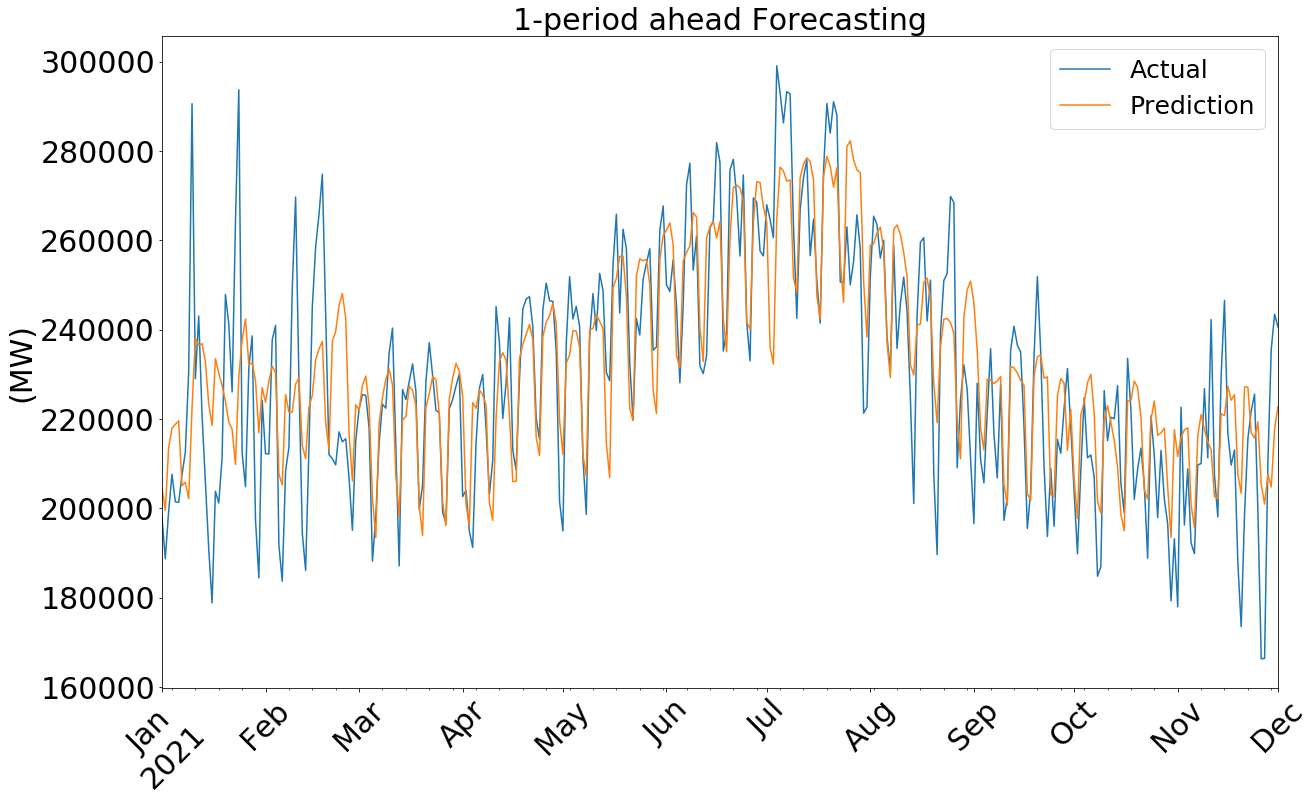

In [88]:
plt.figure(figsize=(20,12))
test_df[["target_t1", "pred_t1"]].plot(figsize=(20,12))
label=['Actual','Prediction']
plt.title("1-period ahead Forecasting",fontsize=30)
plt.xticks(rotation=45,fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("(MW)",fontsize=30)
plt.xlabel('')
plt.legend(label,fontsize=25)
plt.show()